In [1]:
t_end = 'Now'
duration_in_day = 5

CIP1 0.012312734097430434
CIP2 0.01194493339114307
CIP3 0.012338029518469422
CIP4 0.011858859213123237
CIP5 0.012627573228809072
CIP6 0.012546403431459891


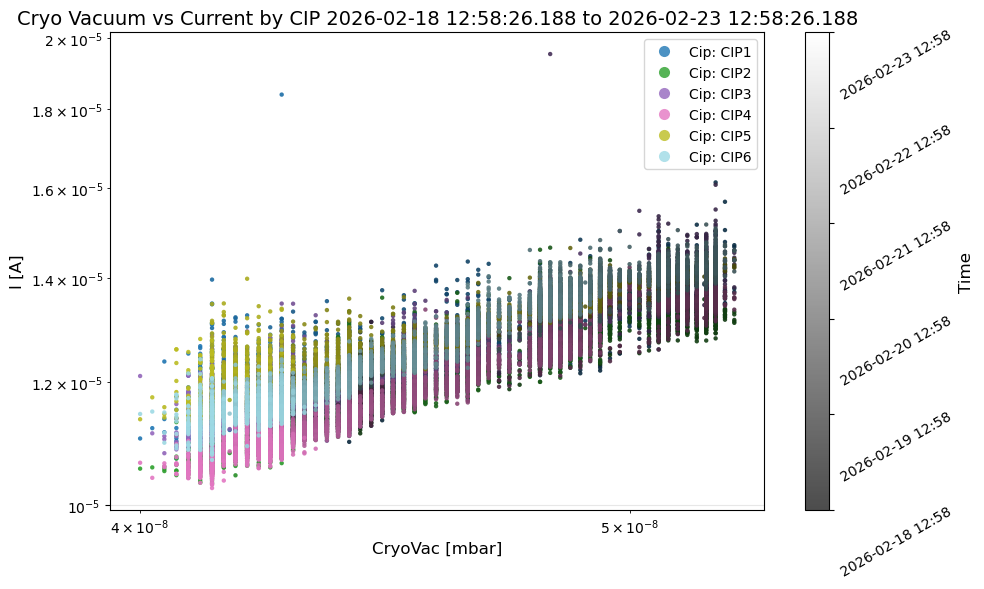

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lsst_efd_client import EfdClient
from astropy.time import Time, TimeDelta
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D

offset={
    "CIP1": -0.003171139293246799,
    "CIP2": -0.00802408324347602,
    "CIP3": -0.006236367755466037,
    "CIP4": 0.004754777307863589,
    "CIP5": -0.006450745794508193,
    "CIP6": 0.009414226920516402
}
# Initialize client
client = EfdClient("usdf_efd")
print(client)

# Define time range for queries (last 90 days)
# Prepare time range
if t_end == 'Now':
    t_end_val = Time.now()
else:
    t_end_val = Time(t_end)
t_start_val = t_end_val - TimeDelta(duration_in_day, format='jd')

t_start = t_start_val.iso
t_end_iso = t_end_val.iso

bin='1m'
# Query 1: CryoVac data
query1 = f"""SELECT mean("CryoVac") AS "mean_CryoVac" FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.vacuum_cryo" 
WHERE time > '{t_start}' AND time < '{t_end_iso}' 
GROUP BY time({bin}) FILL(null)"""

# Query 2: I data with Cip grouping
query2 = f"""SELECT mean("I") AS "mean_I" FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.vacuum_cryo_cip" 
WHERE time > '{t_start}' AND time < '{t_end_iso}' 
GROUP BY time({bin}), "Cip" FILL(null)"""

# Execute queries asynchronously
result1 = await client.influx_client.query(query1)
result2 = await client.influx_client.query(query2)

# Convert results to DataFrames
if isinstance(result1, pd.DataFrame):
    df1 = result1
elif isinstance(result1, dict):
    df1 = list(result1.values())[0] if result1 else pd.DataFrame()
elif isinstance(result1, list):
    df1 = result1[0] if result1 else pd.DataFrame()
else:
    df1 = pd.DataFrame()

# For result2, combine all CIP DataFrames since it's grouped by Cip
if isinstance(result2, dict):
    # Concatenate all DataFrames from the dictionary
    dfs_list = [df for df in result2.values() if isinstance(df, pd.DataFrame) and not df.empty]
    df2 = pd.concat(dfs_list) if dfs_list else pd.DataFrame()
elif isinstance(result2, pd.DataFrame):
    df2 = result2
elif isinstance(result2, list):
    df2 = result2[0] if result2 else pd.DataFrame()
else:
    df2 = pd.DataFrame()

# Rename columns for clarity
if not df1.empty:
    df1 = df1.rename(columns={'mean_CryoVac': 'CryoVac'})
if not df2.empty:
    df2 = df2.rename(columns={'mean_I': 'I'})

# Merge the two dataframes on time index
df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how='inner')

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique Cip values and create base colors
unique_cips = df_merged['Cip'].unique()
base_cmap = plt.get_cmap('tab20', len(unique_cips))
base_colors = [base_cmap(i) for i in range(len(unique_cips))]

# Time-based brightness (earlier -> darker, later -> brighter)
time_index = pd.to_datetime(df_merged.index)
time_num = time_index.view('int64').astype(float)
time_norm = mcolors.Normalize(vmin=np.nanmin(time_num), vmax=np.nanmax(time_num))
brightness = 0.3 + 0.7 * time_norm(time_num)
brightness = np.asarray(brightness, dtype=float)

# Build legend handles with fixed bright colors (independent of time brightness)
legend_handles = []

# Plot each Cip with CIP-based hue and time-based brightness
for i, cip in enumerate(unique_cips):
    mask = df_merged['Cip'] == cip
    base_rgb = np.array(mcolors.to_rgb(base_colors[i]))
    b = brightness[mask.to_numpy()].reshape(-1, 1)
    colors = np.clip(base_rgb * b, 0, 1).astype(float)
    ax.scatter(df_merged[mask]['CryoVac']*1.3333, (df_merged[mask]['I']-offset[cip])/1000, 
        color=colors, alpha=0.9, s=10, edgecolors='none')
    legend_color = np.clip(base_rgb * 0.8 + 0.2, 0, 1)
    legend_handles.append(Line2D([0], [0], marker='o', linestyle='None',
        markerfacecolor=legend_color, markeredgecolor='none', markersize=8,
        label=f'Cip: {cip}'))
    print(cip, np.mean(df_merged[mask]['I']-offset[cip]))

# Colorbar for time (brightness scale)
bright_greys = mcolors.LinearSegmentedColormap.from_list(
    'bright_greys', [(0.3, 0.3, 0.3), (1, 1, 1)]
 )
sm = plt.cm.ScalarMappable(cmap=bright_greys, norm=time_norm)
sm.set_array([])
ticks = np.linspace(np.nanmin(time_num), np.nanmax(time_num), 6)
cbar = fig.colorbar(sm, ax=ax, ticks=ticks)
cbar.set_label('Time', fontsize=12)
tick_labels = pd.to_datetime(ticks).strftime('%Y-%m-%d %H:%M')
cbar.ax.set_yticklabels(tick_labels, rotation=30)

ax.set_xlabel('CryoVac [mbar]', fontsize=12)
ax.set_ylabel('I [A]', fontsize=12)
ax.loglog()
ax.set_title(f'Cryo Vacuum vs Current by CIP {t_start} to {t_end_iso}', fontsize=14)
ax.legend(handles=legend_handles)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

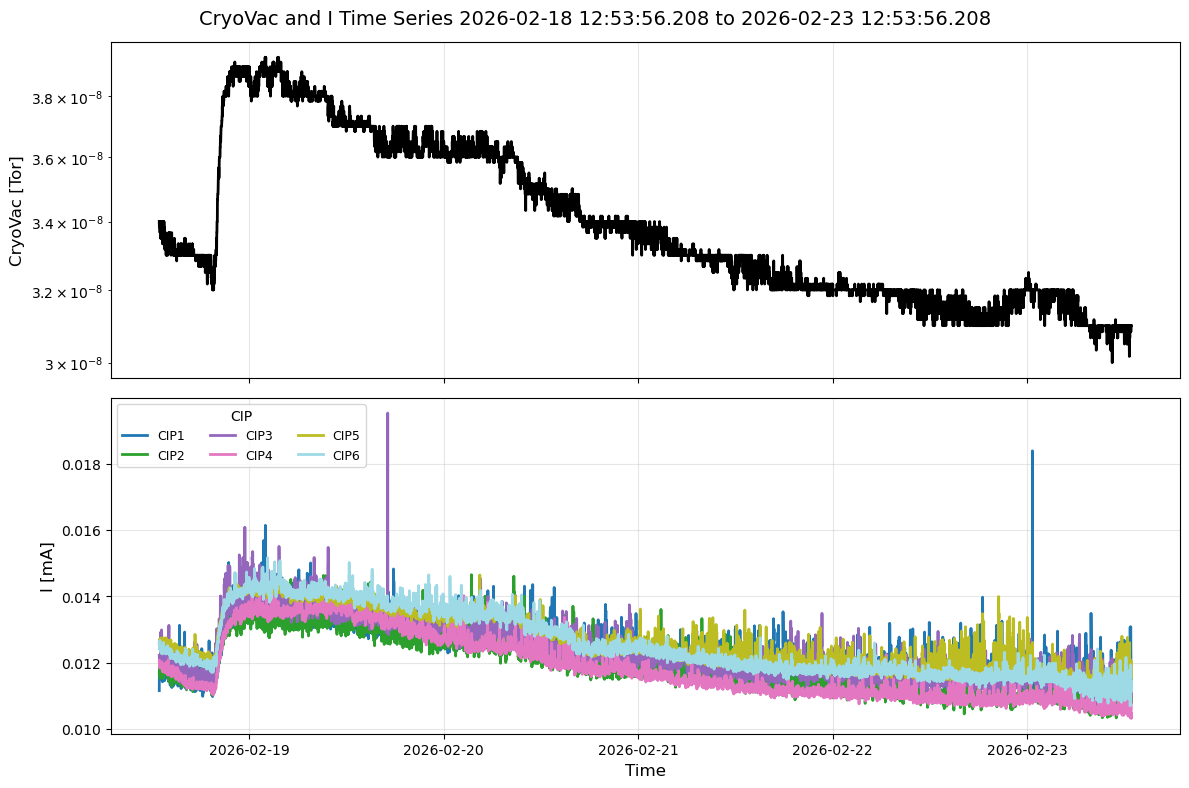

In [3]:
# Time-series plot: CryoVac and I for each CIP
if 'df1' not in globals() or 'df2' not in globals():
    raise RuntimeError('Run Cell 1 first to load df1/df2.')

df_cryo = df1.copy()
df_i = df2.copy()

if 'CryoVac' not in df_cryo.columns and 'mean_CryoVac' in df_cryo.columns:
    df_cryo = df_cryo.rename(columns={'mean_CryoVac': 'CryoVac'})
if 'I' not in df_i.columns and 'mean_I' in df_i.columns:
    df_i = df_i.rename(columns={'mean_I': 'I'})

if df_cryo.empty or df_i.empty:
    raise ValueError('CryoVac or I data is empty. Check query results in Cell 1.')
if 'CryoVac' not in df_cryo.columns or 'I' not in df_i.columns or 'Cip' not in df_i.columns:
    raise KeyError(f'Missing required columns. df1={list(df_cryo.columns)}, df2={list(df_i.columns)}')

# Sort by time for clean time-series lines
df_cryo = df_cryo.sort_index()
df_i = df_i.sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# CryoVac vs time
ax1.plot(df_cryo.index, df_cryo['CryoVac'], color='black', linewidth=2)
ax1.set_ylabel('CryoVac [Tor]', fontsize=12)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# I vs time for each CIP
cips = sorted(df_i['Cip'].dropna().unique())
cmap = plt.get_cmap('tab20', len(cips))
for i, cip in enumerate(cips):
    sub = df_i[df_i['Cip'] == cip]
    y = (sub['I'] - offset.get(cip, 0.0)) / 1.0
    ax2.plot(sub.index, y, linewidth=2.0, color=cmap(i), label=f'{cip}')

ax2.set_ylabel('I [mA]', fontsize=12)
ax2.set_xlabel('Time', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='CIP', ncol=3, fontsize=9)

plot_title = f'CryoVac and I Time Series {t_start} to {t_end_iso}' if 't_start' in globals() and 't_end_iso' in globals() else 'CryoVac and I Time Series'
fig.suptitle(plot_title, fontsize=14)
plt.tight_layout()
plt.show()